# Setup Spark in Google Colab
*reference: https://www.analyticsvidhya.com/blog/2020/11/a-must-read-guide-on-how-to-work-with-pyspark-on-google-colab-for-data-scientists/*


*to install other versions, get the download link from https://spark.apache.org/downloads.html*

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [ ]:
!wget https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz

--2023-11-08 01:29:46--  https://dlcdn.apache.org/spark/spark-3.3.3/spark-3.3.3-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299426263 (286M) [application/x-gzip]
Saving to: ‘spark-3.3.3-bin-hadoop3.tgz’

spark-3.3.3-bin-had 100%[===================>] 285.55M   118MB/s    in 2.4s    

2023-11-08 01:29:49 (118 MB/s) - ‘spark-3.3.3-bin-hadoop3.tgz’ saved [299426263/299426263]



In [ ]:
!tar -xvf spark-3.3.3-bin-hadoop3.tgz

spark-3.3.3-bin-hadoop3/
spark-3.3.3-bin-hadoop3/LICENSE
spark-3.3.3-bin-hadoop3/NOTICE
spark-3.3.3-bin-hadoop3/R/
spark-3.3.3-bin-hadoop3/R/lib/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/DESCRIPTION
spark-3.3.3-bin-hadoop3/R/lib/SparkR/INDEX
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/Rd.rds
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/features.rds
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/hsearch.rds
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/links.rds
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/nsInfo.rds
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/package.rds
spark-3.3.3-bin-hadoop3/R/lib/SparkR/Meta/vignette.rds
spark-3.3.3-bin-hadoop3/R/lib/SparkR/NAMESPACE
spark-3.3.3-bin-hadoop3/R/lib/SparkR/R/
spark-3.3.3-bin-hadoop3/R/lib/SparkR/R/SparkR
spark-3.3.3-bin-hadoop3/R/lib/SparkR/R/SparkR.rdb
spark-3.3.3-bin-hadoop3/R/lib/SparkR/R/SparkR.rdx
spark-3.3.3-bin-hadoop3/R/lib/SparkR/doc/
spark-3.3.3-bin-hadoop3/R/lib/Spar

In [ ]:
!pip install findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.3-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
findspark.find()

'/content/spark-3.3.3-bin-hadoop3'

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
sc = spark.sparkContext

In [ ]:
test = sc.parallelize([1, 2, 3, 4, 5])
test.map(lambda x: (x, x**2)).collect()

[(1, 1), (2, 4), (3, 9), (4, 16), (5, 25)]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#List of file names
file_names = ['the_weeknd.csv', 'taylor_swift.csv', 'sza.csv', 'rihanna.csv', 'justin_bieber.csv', 'ed_sheeran.csv', 'drake.csv', 'doja_cat.csv', 'billie_eilish.csv', 'bad_bunny.csv']

# Initialize an empty DataFrame to union all your DataFrames
combined_df = None

# Loop over the file names, read each into a DataFrame, and combine them
for file_name in file_names:
    file_path = f'/content/drive/My Drive/raw-csvs-top-10/{file_name}'
    # Read the CSV file into a DataFrame
    df = spark.read.csv(file_path, header=True, inferSchema=True)
    # Union the DataFrames
    if combined_df is None:
        combined_df = df
    else:
        combined_df = combined_df.union(df)

# Now `combined_df` contains all the data from the 10 CSV files
combined_df.show(5)  # Show the first 5 rows

+--------------------+--------------------+--------------------+--------------------+--------------+-------------------+-------------+----------+--------------------+-------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|          Spotify ID|          Artist IDs|          Track Name|          Album Name|Artist Name(s)|       Release Date|Duration (ms)|Popularity|            Added By|           Added At|              Genres|Danceability|Energy|Key|Loudness|Mode|Speechiness|Acousticness|Instrumentalness|Liveness|Valence|  Tempo|Time Signature|
+--------------------+--------------------+--------------------+--------------------+--------------+-------------------+-------------+----------+--------------------+-------------------+--------------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|2ye9iWj5V4g6k6H

In [ ]:
from pyspark.sql.functions import col, split

row_count_before_clean = combined_df.count()
print(f"The number of rows before data cleaning is: {row_count_before_clean}")

# List of top 10 artist names:
top_10_artist_names = ["The Weeknd", "Taylor Swift", "SZA", "Rihanna", "Justin Bieber", "Ed Sheeran", "Drake", "Doja Cat", "Billie Eilish", "Bad Bunny"]

# 1. Filter entries where the first artist listed in "Artist Name(s)" is one of the top 10 artists
filtered_df = combined_df.withColumn("FirstArtist", split(col("Artist Name(s)"), ",").getItem(0)) \
                         .filter(col("FirstArtist").isin(top_10_artist_names))

# 2. Remove duplicates based on 'Track Name'
no_duplicates_df = filtered_df.dropDuplicates(["Track Name"])

# 3. Remove live versions of songs
# Filter out rows where 'Track Name' contains "- Live" or "Live Version"
cleaned_df = no_duplicates_df.filter(~col("Track Name").like("%- Live%") &
                                     ~col("Track Name").like("%Live Version%"))

row_count_clean = cleaned_df.count()
print(f"Removed duplicates, live versions, and tracks where the top 10 artist is NOT a primary artist.")
print(f"The number of rows after data cleaning is: {row_count_clean}")


The number of rows before data cleaning is: 3084
Removed duplicates, live versions, and tracks where the top 10 artist is NOT a primary artist.
The number of rows after data cleaning is: 1906


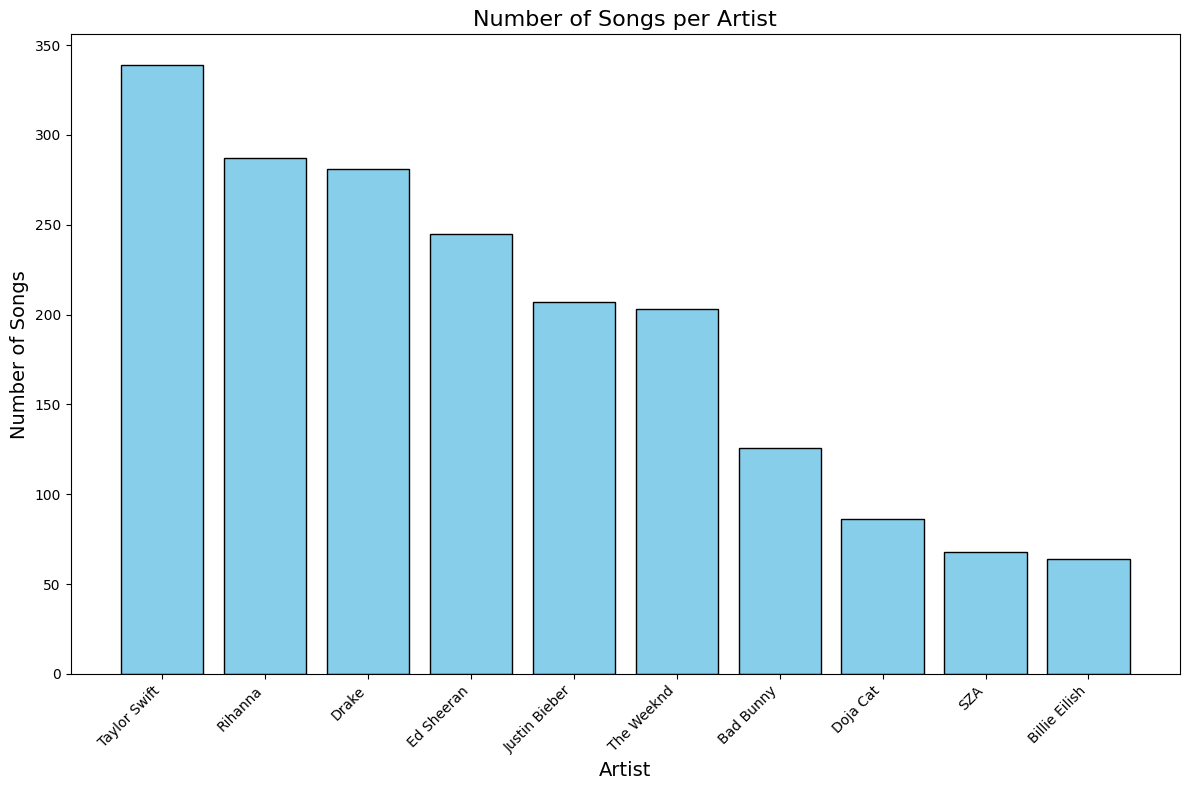

Visualization of number of songs per artist. OK I see you T-Swift!


In [ ]:
import matplotlib.pyplot as plt

# Make sure your DataFrame column names match, particularly "FirstArtist" here
artist_song_counts = cleaned_df.groupBy(col("FirstArtist")).count()

# Convert to Pandas DataFrame for plotting
artist_song_counts_pd = artist_song_counts.toPandas()

# Sort the data
artist_song_counts_pd.sort_values(by='count', ascending=False, inplace=True)

# Plotting
plt.figure(figsize=(12, 8))
plt.bar(artist_song_counts_pd['FirstArtist'], artist_song_counts_pd['count'], color='skyblue', edgecolor ='black')
plt.xlabel('Artist', fontsize=14)
plt.ylabel('Number of Songs', fontsize=14)
plt.title('Number of Songs per Artist', fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate for better readability
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

print(f"Visualization of number of songs per artist. OK I see you T-Swift!")

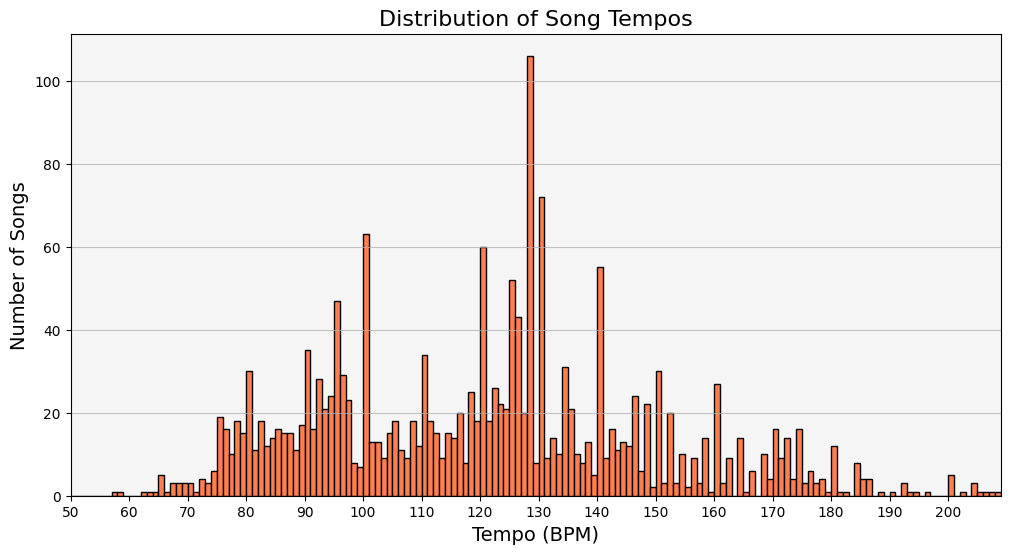

The most popular tempo in the dataset is 128 BPM, which is found in 106 tracks.


In [ ]:
from pyspark.sql.functions import round, col, count
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

# Add a new column with the rounded tempo values
cleaned_df = cleaned_df.withColumn("RoundedTempo", round("Tempo").cast('integer'))

# Now we convert the DataFrame to Pandas for visualization
tempo_pd = cleaned_df.select('RoundedTempo').toPandas()

# Plotting
plt.figure(figsize=(12, 6))
plt.hist(tempo_pd['RoundedTempo'], bins=range(50, int(tempo_pd['RoundedTempo'].max()) + 1, 1), color='coral', edgecolor='black')
plt.xticks(np.arange(50, int(tempo_pd['RoundedTempo'].max()) + 1, 10))
plt.xlim(50, int(tempo_pd['RoundedTempo'].max()))  # Set the limit of x-axis to 50 minimum
plt.xlabel('Tempo (BPM)', fontsize=14)
plt.ylabel('Number of Songs', fontsize=14)
plt.title('Distribution of Song Tempos', fontsize=16)
plt.grid(axis='y', alpha=0.75)
plt.gca().set_facecolor('whitesmoke')
plt.show()

# Calculate and print the mode

# Group by the RoundedTempo column and count the number of occurrences of each tempo
tempo_frequency = cleaned_df.groupBy("RoundedTempo").agg(count("RoundedTempo").alias("Frequency"))
mode_row = tempo_frequency.orderBy(col("Frequency").desc()).first()
mode_tempo = mode_row["RoundedTempo"]
mode_frequency = mode_row["Frequency"]
print(f"The most popular tempo in the dataset is {mode_tempo} BPM, which is found in {mode_frequency} tracks.")


An interesting observation from the histogram above: note how the frequency seems to jump up significantly at every multiple of 10! (e.g. 140 BPM vs 139 or 141)

**Let's analyze keys next:**

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Defining a new python function to derive the tonal key into a legible format (e.g. C major, F minor) based on numerical audio features extracted from the dataframe.
def get_tonal_key(key, mode):
    # Mapping defined: first entry is the 'key' audio feature, second entry is the 'mode' audio feature
    mapping = {
        (0, 0): "C min",
        (1, 0): "C# min",
        (2, 0): "D min",
        (3, 0): "D# min",
        (4, 0): "E min",
        (5, 0): "F min",
        (6, 0): "F# min",
        (7, 0): "G min",
        (8, 0): "G# min",
        (9, 0): "A min",
        (10, 0): "A# min",
        (11, 0): "B min",
        (0, 1): "C maj",
        (1, 1): "C# maj",
        (2, 1): "D maj",
        (3, 1): "D# maj",
        (4, 1): "E maj",
        (5, 1): "F maj",
        (6, 1): "F# maj",
        (7, 1): "G maj",
        (8, 1): "G# maj",
        (9, 1): "A maj",
        (10, 1): "A# maj",
        (11, 1): "B maj",

        (-1, 0): "No Key Detected",
        (-1, 1): "No Key Detected",
    }

    return mapping.get((key, mode))

# Register the UDF
get_tonal_key_udf = udf(get_tonal_key, StringType())

# Apply the UDF to create the new column 'TonalKey'
cleaned_df = cleaned_df.withColumn("TonalKey", get_tonal_key_udf(cleaned_df["Key"], cleaned_df["Mode"]))

# Show some results to verify
cleaned_df.select("Key", "Mode", "TonalKey").show()


+---+----+--------+
|Key|Mode|TonalKey|
+---+----+--------+
|  5|   0|   F min|
| 11|   0|   B min|
|  7|   1|   G maj|
|  6|   0|  F# min|
|  0|   0|   C min|
|  5|   0|   F min|
|  3|   0|  D# min|
|  0|   1|   C maj|
|  1|   1|  C# maj|
|  0|   1|   C maj|
|  6|   0|  F# min|
|  5|   0|   F min|
|  5|   0|   F min|
|  1|   0|  C# min|
|  4|   0|   E min|
| 10|   0|  A# min|
|  0|   0|   C min|
|  1|   0|  C# min|
|  0|   0|   C min|
|  9|   0|   A min|
+---+----+--------+
only showing top 20 rows



The mapping was successful. Let's analyze some data with respect to these keys now.

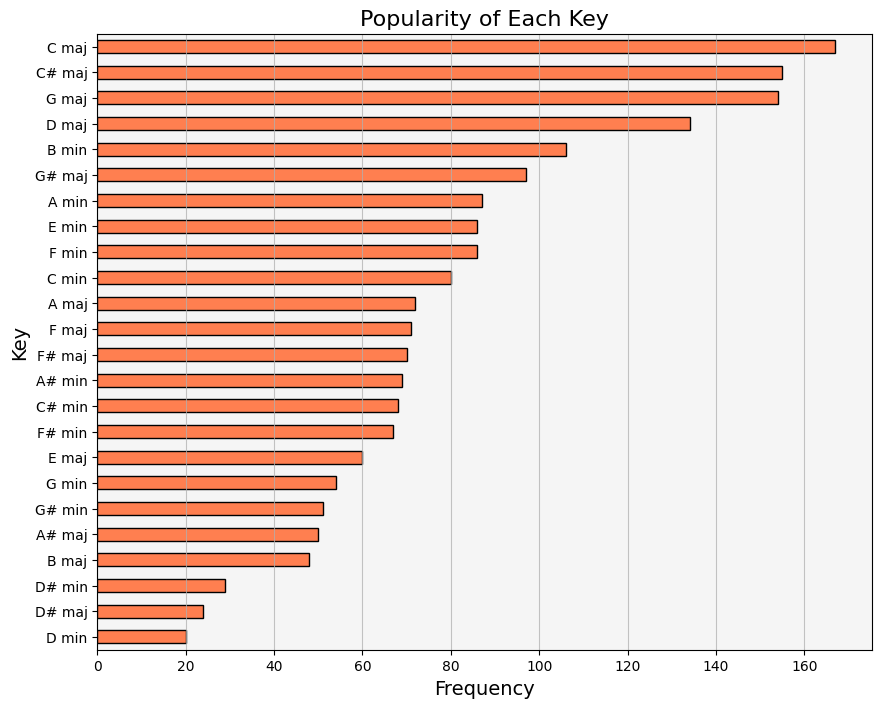

In [ ]:
import matplotlib.pyplot as plt

# Convert the DataFrame to Pandas for plotting
tonal_key_pd = cleaned_df.select('TonalKey').toPandas()

# Calculate the frequency of each TonalKey
tonal_key_counts = tonal_key_pd['TonalKey'].value_counts()

# Sort the TonalKey by count for better visualization
tonal_key_counts_sorted = tonal_key_counts.sort_values()

# Plotting
plt.figure(figsize=(10, 8))
tonal_key_counts_sorted.plot(kind='barh', color='coral', edgecolor='black')
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Key', fontsize=14)
plt.title('Popularity of Each Key', fontsize=16)
plt.grid(axis='x', alpha=0.75)
plt.gca().set_facecolor('whitesmoke')
plt.show()


C major is the most popular key in this dataset. It's also the simplest key, involving only the white keys on the piano. It's the easiest key to play and often the first one that musicians are introduced to. Looks like 'simple' translates to 'popular' in the realm of pop music.

Ok, let's combine those features now and look at the most common key / tempo combinations:

<Figure size 1200x800 with 0 Axes>

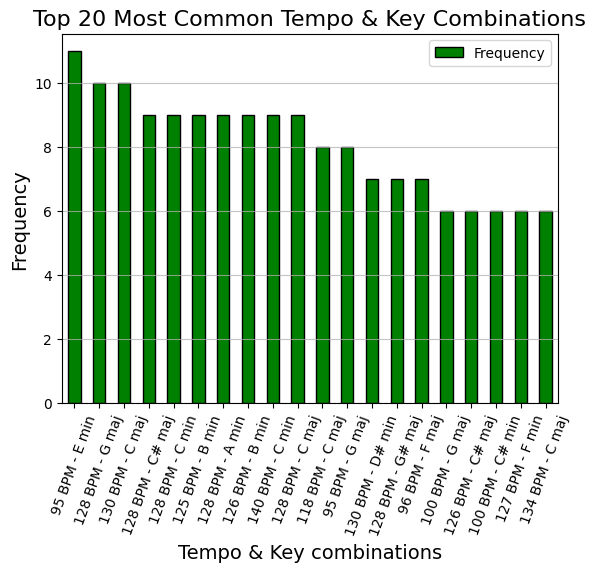

In [ ]:
from pyspark.sql.functions import desc

# Group by 'RoundedTempo' and 'TonalKey', count, and sort
common_combinations_df = cleaned_df.groupBy('RoundedTempo', 'TonalKey') \
                                   .count() \
                                   .withColumnRenamed('count', 'Frequency') \
                                   .orderBy(desc('Frequency'))

# Take top 15 most common combinations
top_common_combinations_df = common_combinations_df.limit(20)

# Convert to Pandas DataFrame for visualization
top_common_combinations_pd = top_common_combinations_df.toPandas()

# Plotting
plt.figure(figsize=(12, 8))
top_common_combinations_pd.plot(kind='bar', x='TonalKey', y='Frequency', color='green', edgecolor='black')
plt.xlabel('Tempo & Key combinations', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Most Common Tempo & Key Combinations', fontsize=16)
plt.xticks(range(len(top_common_combinations_pd)), labels=[f"{row['RoundedTempo']} BPM - {row['TonalKey']}" for index, row in top_common_combinations_pd.iterrows()], rotation=70)
plt.grid(axis='y', alpha=0.75)
plt.show()


TODO: Investigate relationships between some of the features and the target variable, 'popularity'.

Potential plots:
popularity vs energy
popularity vs danceability
popularity vs key
popularity vs tempo

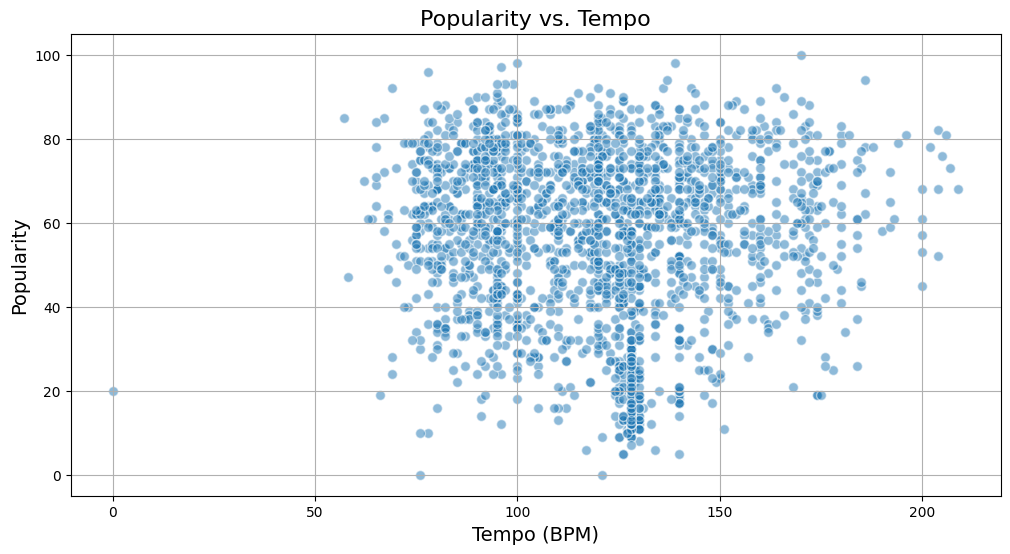

Number of NaNs in Popularity: 0
Number of NaNs in RoundedTempo: 0


In [ ]:

# Filter the DataFrame for Popularity values of 80 and above
high_popularity_df = cleaned_df.filter(cleaned_df['Popularity'] >= 0)

# Convert the necessary columns to Pandas DataFrame for visualization
high_popularity_tempo_pd = high_popularity_df.select('Popularity', 'RoundedTempo').toPandas()
high_popularity_tempo_pd_clean= high_popularity_tempo_pd.dropna(subset=['RoundedTempo'])

# Scatterplot
plt.figure(figsize=(12, 6))
plt.scatter(high_popularity_tempo_pd_clean['RoundedTempo'], high_popularity_tempo_pd_clean['Popularity'], alpha=0.5, edgecolors='w', s=50)
plt.title('Popularity vs. Tempo', fontsize=16)
plt.xlabel('Tempo (BPM)', fontsize=14)
plt.ylabel('Popularity', fontsize=14)
plt.grid(True)
plt.show()

# Check for NaN values in 'Popularity'
nan_popularity = high_popularity_tempo_pd_clean['Popularity'].isna().sum()
print(f"Number of NaNs in Popularity: {nan_popularity}")

# Check for NaN values in 'RoundedTempo'
nan_rounded_tempo = high_popularity_tempo_pd_clean['RoundedTempo'].isna().sum()
print(f"Number of NaNs in RoundedTempo: {nan_rounded_tempo}")


The first impression upon looking at this scatterplot is that there is little to no correlation between tempo and popularity for this dataframe. We can evaluate this more objectively by calculating the Pearson correlation coefficient. This value ranges from -1 to 1, where 1 means a perfect positive correlation, -1 means a perfect negative correlation, and 0 means no linear correlation.

In [ ]:
from scipy.stats import pearsonr

# Assuming high_popularity_tempo_pd is your pandas dataframe
# and it has 'RoundedTempo' and 'Popularity' columns
correlation_coef, p_value = pearsonr(high_popularity_tempo_pd_clean['RoundedTempo'], high_popularity_tempo_pd_clean['Popularity'])

print(f"Pearson correlation coefficient: {correlation_coef}")


Pearson correlation coefficient: -0.01493394424847474


Next we can look at danceabaility and popularity.


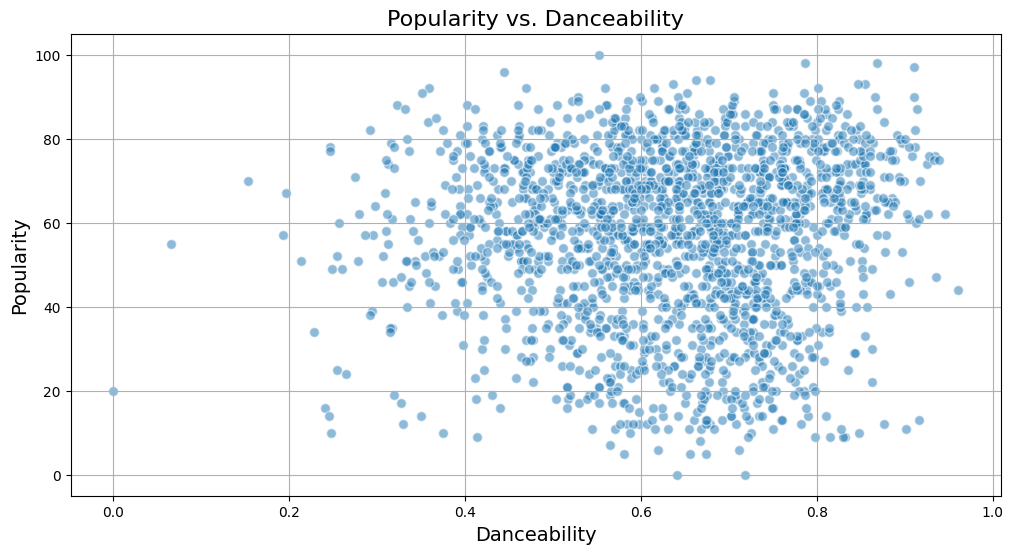

Pearson correlation coefficient: 0.04554451502389938


In [ ]:
# Convert the necessary columns to Pandas DataFrame for visualization
popularity_danceability_pd = cleaned_df.select('Popularity', 'Danceability').toPandas()
popularity_danceability_pd= popularity_danceability_pd.dropna(subset=['Danceability'])

# Scatterplot
plt.figure(figsize=(12, 6))
plt.scatter(popularity_danceability_pd['Danceability'], popularity_danceability_pd['Popularity'], alpha=0.5, edgecolors='w', s=50)
plt.title('Popularity vs. Danceability', fontsize=16)
plt.xlabel('Danceability', fontsize=14)
plt.ylabel('Popularity', fontsize=14)
plt.grid(True)
plt.show()

correlation_coef, p_value = pearsonr(popularity_danceability_pd['Danceability'], popularity_danceability_pd['Popularity'])
print(f"Pearson correlation coefficient: {correlation_coef}")

Looks like there isn't much correlation between danceability and popularity either! (which is an interesting observation in and of itself)

Back to our original target variable, Popularity.

Below, a linear regression model and random forest regression model are both applied to the dataset, using all ordinal numerical values as features. Key is not included as a feature because the integers are not ordinal (i.e. ranges from 0 to 11 cyclically, the jump from 0 to 1 is the same as the jump from 11 to 0).

In [ ]:
# Check column data types
for column in df.dtypes:
    print(column)


('Spotify ID', 'string')
('Artist IDs', 'string')
('Track Name', 'string')
('Album Name', 'string')
('Artist Name(s)', 'string')
('Release Date', 'timestamp')
('Duration (ms)', 'int')
('Popularity', 'int')
('Added By', 'string')
('Added At', 'timestamp')
('Genres', 'string')
('Danceability', 'double')
('Energy', 'double')
('Key', 'int')
('Loudness', 'double')
('Mode', 'int')
('Speechiness', 'double')
('Acousticness', 'double')
('Instrumentalness', 'double')
('Liveness', 'double')
('Valence', 'double')
('Tempo', 'double')
('Time Signature', 'int')


In [ ]:
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Assuming cleaned_df is a PySpark DataFrame and a Spark session is already started
# Convert cleaned_df to a Pandas DataFrame
pandas_cleaned_df = cleaned_df.toPandas()

# Prepare the features and target variable for the entire modeling process
X = pandas_cleaned_df[['Danceability', 'Energy', 'Tempo', 'Acousticness', 'Valence', 'Loudness', 'Liveness', 'Mode', 'Instrumentalness', 'Speechiness']]
# X = pandas_cleaned_df[['Acousticness', 'Danceability', 'Mode', 'Speechiness']]
y = pandas_cleaned_df['Popularity']

# Handle missing values if there are any
X = X.fillna(X.mean())

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Fit the Linear Regression model on the training data
linear_model.fit(X_train, y_train)

# Predicting the Test set results
y_pred = linear_model.predict(X_test)

# Evaluating the Linear Regression model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Linear Regression - Mean Squared Error: {mse:.3f}")
print(f"Linear Regression - R^2 Score: {r2:.3f}")


# Initialize the RandomForestRegressor
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Perform cross-validation on the standardized features and target
rf_scores = cross_val_score(random_forest_model, X_scaled, y, cv=5, scoring='r2')

# Print out the mean of the cross-validation scores for Random Forest
print(f"Random Forest - Average R^2 Score from cross-validation: {rf_scores.mean():.3f}")


/content/spark-3.3.3-bin-hadoop3/python/pyspark/sql/pandas/conversion.py:248: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


Linear Regression - Mean Squared Error: 362.298
Linear Regression - R^2 Score: 0.153
Random Forest - Average R^2 Score from cross-validation: 0.257


So the Linear Regression R^2 score is quite low at 0.153.

The Random Forest model gave us a marginally higher R^2 score at 0.257, which isn't excellent but it's an improvement.

An R^2 score of 0.257, especially with this large of a dataset and most likely some noisy datapoints, certainly indicates some level of correlation, but probably not enough to confidently predict popularity based on the other features, at least for this dataset.

Let's do a correlational matrix of all the selected features to see how some of them may relate to each other.

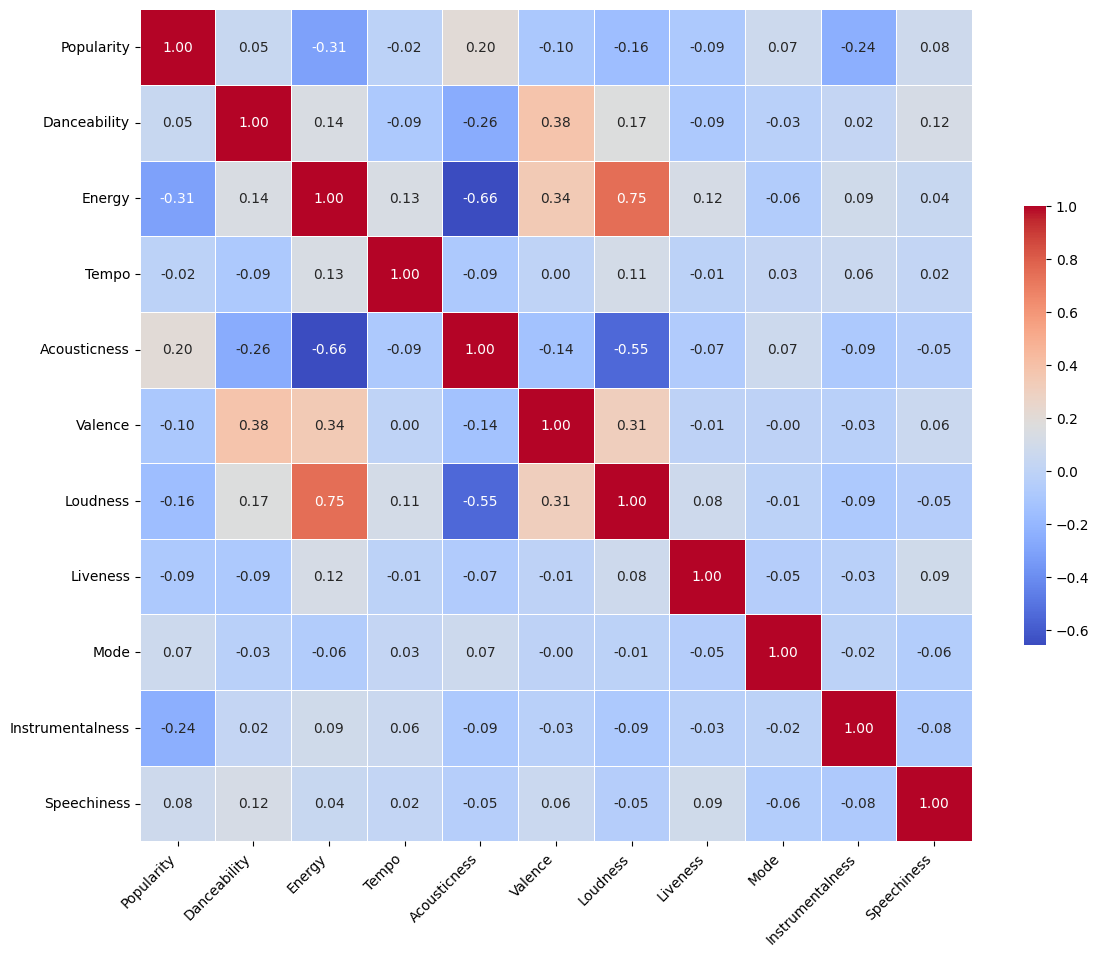

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numerical feature columns to be included in the correlational matrix
selected_columns = ['Popularity', 'Danceability', 'Energy', 'Tempo', 'Acousticness', 'Valence', 'Loudness', 'Liveness', 'Mode', 'Instrumentalness', 'Speechiness']

# Select only the specified columns for correlation
selected_df = pandas_cleaned_df[selected_columns]

# Compute the correlation matrix for the selected columns
corr = selected_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Optional: Adjust the layout
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()  # Adjust layout to fit everything

# Show the plot
plt.show()


Some observations:
- Popularity doesn't seem very correlated with any of the individual features.
- Loudness and Energy are pretty highly correlated.
- Acousticness is highly inversely correlated with both Loudness and Energy.
- Energy and Popularity have a -0.3 correlation which I find somnewhat surprising.
- Valence (i.e. 'moodiness') is incersely correlated with danceability, energy, and loudness, which is no real surprise.
